In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('../../../../')
print(os.getcwd())
from v2.strategy.indicators.optimal_v2 import Optimal_v2
from v2.model import Trading
from v2.strategy.indicators.param import Param
from v2.strategy.indicators.roc import RateOfChange
from v2.research.scripts.notebook_utils import notebookUtils
from v2.research.scripts.scoreboard import updateScoreboard
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance


/Users/rosscopeland/Desktop/personal/code/vivaldi/back_testing


In [2]:
nu = notebookUtils()
model_name = "ENSEMBLE_CHANGE_THIS"

In [3]:
dataset, features, indicators = nu.loadData(indicators=[('rsi', 'close'), ('optimal_v2', 'close')],
                            param_spec={},
                            optimal_threshold={'buy':0.55},
                            spans=[{'indicator_name':'willr',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'cci',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'rsi',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'momentum',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'roc',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'momentum',
                                    'column_name': 'RSI',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'roc',
                                    'column_name': 'RSI',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]}
                                    ],

                            scale='minmaxwindow')
        
    # create one minute, five minute, ten minute, and twenty minute slopes for macd, rsi




Loading data from BTC...
Loading data from chunk 0...
Loading data from chunk 1...
Loading data from chunk 2...
Loading data from chunk 3...
Loading data from chunk 4...
Loading data from chunk 5...
Loading data from chunk 6...
Loading data from chunk 7...
Loading data from chunk 8...
Loading data from chunk 9...
Loading data from chunk 10...


In [27]:
edit_dataset = dataset.drop(["time", "open", "high", "low"], axis=1)
edit_dataset.dropna(inplace=True)
edit_dataset

,close,volume,RSI,optimal,WILLR_close_period_3,WILLR_close_period_5,WILLR_close_period_10,WILLR_close_period_30,CCI_close_period_3,CCI_close_period_5,...,RateOfChange_close_period_10,RateOfChange_close_period_30,Momentum_RSI_period_3,Momentum_RSI_period_5,Momentum_RSI_period_10,Momentum_RSI_period_30,RateOfChange_RSI_period_3,RateOfChange_RSI_period_5,RateOfChange_RSI_period_10,RateOfChange_RSI_period_30
15089,3580.562345,0.335707,0.614314,0.0,0.437803,0.506742,0.643094,0.618870,0.954938,0.702998,...,0.321495,0.304660,0.428306,0.459619,0.452706,0.424417,0.330691,0.353429,0.290815,0.354388
15090,3580.286173,0.062379,0.614314,0.0,0.437792,0.506690,0.641844,0.613454,0.234349,0.240597,...,0.327936,0.300851,0.465750,0.459619,0.488195,0.412029,0.359110,0.353429,0.311145,0.344979
15091,3580.148086,0.061036,0.614314,0.0,0.437787,0.506665,0.641218,0.610747,0.247454,0.323662,...,0.331162,0.298948,0.465750,0.428306,0.488195,0.412029,0.359110,0.329749,0.311145,0.344979
15092,3580.079043,0.000000,0.614314,0.0,0.438562,0.506653,0.595814,0.609393,0.100000,0.364825,...,0.332776,0.297998,0.465750,0.465750,0.488195,0.412029,0.359110,0.358208,0.311145,0.344979
15093,3580.044522,0.414935,0.614314,0.0,0.439128,0.506647,0.595579,0.608716,0.178633,0.372552,...,0.323395,0.285390,0.465750,0.465750,0.456748,0.331146,0.359110,0.358208,0.293070,0.289171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483226,18519.207620,5.437391,0.456972,0.0,0.519744,0.428394,0.126793,0.031906,0.863859,0.392106,...,0.606396,0.596548,0.578584,0.565483,0.502199,0.235076,0.501016,0.508435,0.375851,0.173065
1483227,18523.983810,65.068932,0.471670,0.0,0.201420,0.200015,0.221838,0.088531,1.000000,1.000000,...,0.610412,0.597902,0.624840,0.567331,0.518435,0.273425,0.539331,0.509864,0.390231,0.196494
1483228,18525.301905,15.367476,0.467947,0.0,0.232852,0.231499,0.252022,0.102116,0.520601,0.629556,...,0.621583,0.602735,0.619499,0.576487,0.566444,0.306899,0.534936,0.517413,0.432292,0.215707
1483229,18526.950952,54.298657,0.471514,0.0,0.272175,0.270887,0.289785,0.119112,0.218565,0.561493,...,0.627825,0.601871,0.610117,0.599404,0.570310,0.287385,0.526956,0.536459,0.435807,0.204548


In [28]:
trainX, testX, trainy, testy = nu.splitData(edit_dataset, split_size=0.2, y_column_name="optimal", shuffle_data=False, balance_unbalanced_data=True, balance_info={'multiplier_val':2, 'superset_class_val':0, 'randomize_concat':True})
trainX

,close,volume,RSI,WILLR_close_period_3,WILLR_close_period_5,WILLR_close_period_10,WILLR_close_period_30,CCI_close_period_3,CCI_close_period_5,CCI_close_period_10,...,RateOfChange_close_period_10,RateOfChange_close_period_30,Momentum_RSI_period_3,Momentum_RSI_period_5,Momentum_RSI_period_10,Momentum_RSI_period_30,RateOfChange_RSI_period_3,RateOfChange_RSI_period_5,RateOfChange_RSI_period_10,RateOfChange_RSI_period_30
0,3582.634711,7.356997,0.497035,0.204706,0.068532,0.040976,0.426433,1.000000e+00,0.504981,0.435096,...,0.510882,0.527946,0.494110,0.505174,0.500697,0.490319,0.421687,0.403199,0.401409,0.287360
1,5167.702868,1.900415,0.552087,0.406345,0.429055,0.620952,0.801691,9.222751e-01,0.820469,0.738016,...,0.444826,0.491730,0.609363,0.583550,0.549380,0.538328,0.467639,0.501183,0.465301,0.482359
2,5301.303495,6.985570,0.540496,0.428241,0.527321,0.375302,0.530359,2.412443e-01,0.351575,0.485852,...,0.533472,0.599995,0.432200,0.420142,0.486350,0.575663,0.418303,0.386003,0.446564,0.522902
3,3640.596951,23.264241,0.392414,0.727526,0.488259,0.455886,0.285145,1.690483e-01,0.232196,0.419110,...,0.395849,0.397605,0.368112,0.431864,0.324277,0.553840,0.326963,0.370908,0.267942,0.457155
4,7104.822904,46.763714,0.230184,0.537023,0.643945,0.574716,0.548267,1.179522e-11,0.348288,0.345410,...,0.337857,0.382561,0.692054,0.374241,0.302956,0.377903,0.613211,0.314724,0.193850,0.225245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264304,8078.150753,17.829244,0.456461,0.746558,0.659804,0.928793,0.810164,1.000000e+00,0.820176,0.660788,...,0.473703,0.444920,0.550840,0.532792,0.678599,0.575064,0.540321,0.516431,0.633332,0.486040
264305,5221.715939,7.216941,0.372862,0.582170,0.331854,0.326799,0.128482,7.682783e-02,0.210485,0.282579,...,0.499668,0.514746,0.478056,0.499888,0.450772,0.358342,0.445596,0.443536,0.412262,0.304414
264306,8305.669198,32.495177,0.598153,0.675185,0.749788,0.827292,0.811229,1.000000e+00,0.842089,0.753801,...,0.611968,0.615209,0.672537,0.714308,0.737666,0.633277,0.452308,0.565862,0.446595,0.388055
264307,8060.199626,9.590279,0.625516,0.672012,0.789727,0.652194,0.316215,1.000000e+00,0.886911,0.652147,...,0.609845,0.566397,0.615637,0.634300,0.545882,0.466872,0.445439,0.423201,0.380752,0.282723


In [29]:
class_weights = nu.getWeights(trainy)
class_weights

{0: 0.75, 1: 1.5}

In [30]:
clf1 = XGBClassifier(random_state=69420, class_weight=class_weights, n_jobs=-1, n_estimators=100, criterion='gini', min_samples_leaf=2)
clf1.fit(trainX.drop("close", axis=1).values, trainy.values)

print(clf1.score(testX.drop("close", axis=1).values, testy.values))

# feature_importances = permutation_importance(clf, trainX.drop("close", axis=1).values, trainy.values, n_repeats=10, random_state=69420)

# for i in range(len(feature_importances.importances_mean)):
#     print('i: {}, Feature: {}, Score: {}'.format(i, trainX.drop("close", axis=1).columns[i], feature_importances.importances_mean[i]))

[17:59:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { class_weight, criterion, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.7891628504888004


In [31]:
clf2 = RandomForestClassifier(random_state=69420, class_weight=class_weights, n_jobs=-1, n_estimators=100, criterion='gini', min_samples_leaf=2)
clf2.fit(trainX.drop("close", axis=1).values, trainy.values)

print(clf2.score(testX.drop("close", axis=1).values, testy.values))

# feature_importances = permutation_importance(clf2, trainX.drop("close", axis=1).values, trainy.values, n_repeats=10, random_state=69420)

# for i in range(len(feature_importances.importances_mean)):
#     print('i: {}, Feature: {}, Score: {}'.format(i, trainX.drop("close", axis=1).columns[i], feature_importances.importances_mean[i]))

0.78868206322523


In [59]:
reduced_classified_data = nu.classifyPoints([clf1, clf2], testX, predict_proba=True, proba_thresh=[0.74, 0.6], plot_optimal=True, optimal=testy)

In [62]:
smaller_view_data = reduced_classified_data[2000:3000]
smaller_view_data.reset_index(inplace=True)

<Figure size 432x288 with 0 Axes>

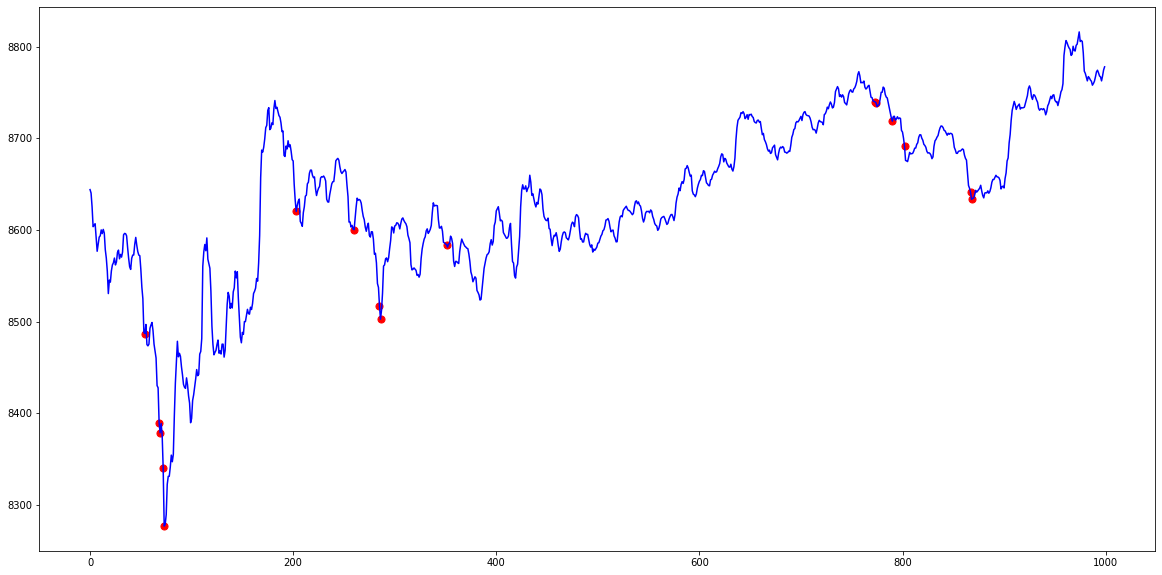

In [63]:
nu.graphPoints(smaller_view_data, mode="buy", plot_optimal=False)

In [12]:
features = ['volume'] + features

In [13]:
model_version = nu.exportModel(clf, model_name, new_version=False, indicators=indicators, features=features, proba_threshold=0.0, is_nn=False)

In [14]:
score, trades = nu.testModel(model_name)

Importing Strategies...
Generating Model Data...
Scaling Model Data...
Preprocessing Model Predictions...
0it [00:00, ?it/s]Generating Algo Data...
Executing Strategy...
105553it [00:00, 311204.92it/s]
Generating Report...


In [15]:
updateScoreboard(model_name, model_version, score, trades, features)